In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

# LangGraph Hot-Swapping & Multi-Agent

In [2]:
%%time
!pip install -q langgraph langchain langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.9 MB/s eta 0:00:00
CPU times: user 1.59 s, sys: 811 ms, total: 2.4 s
Wall time: 7.06 s


In [9]:
!pip install nest_asyncio -q  # Jupyter Notebook에서 비동기 실행을 위해 필요
from IPython.display import Image, display
import nest_asyncio

# 비동기 실행을 위해 필요
nest_asyncio.apply()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import os
from google.colab import userdata

# OpenAI API 키는 필요시 설정 (이번 실습에서는 사용하지 않음)
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## LLM, Tool 정의

In [5]:
from typing import TypedDict, List
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Tool 정의
#  가상 DB에서 공정 파라미터를 조회합
def get_parameter_from_db(step_name: str) -> str:
    print(f"--- TOOL: get_parameter_from_db(step_name='{step_name}') 실행 ---")
    db = {"포토리소그래피": "Dose: 25.0, Focus: -0.05", "식각": "Power: 500, Pressure: 10"}
    return db.get(step_name, "해당 공정 데이터를 찾을 수 없습니다.")

# 데이터에 'Dose' 파라미터가 포함되어 있는지 검사하는 품질 검사 툴
def quality_check(data: str) -> bool:
    print(f"--- TOOL: quality_check(data='{data}') 실행 ---")
    return "Dose" in data

# 그래프의 상태 정의
class AgentState(TypedDict):
    query: str
    tool_output: str
    quality_ok: bool

print("실습용 LLM 및 도구 준비 완료.")

실습용 LLM 및 도구 준비 완료.


## 런타임 그래프 수정 (Hot-Swapping)  
### 기본적인 그래프를 정의한 뒤, 특정 조건에 따라 실행 중에 새로운 '품질 검사' 노드를 동적으로 추가하는 방법



### 기본 그래프 및 '핫스왑' 함수 정의  
> 간단한 2단계 그래프(입력->실행)를 정의하고,   
이 그래프 객체를 인자로 받아 새로운 노드와 엣지를 추가하는 함수를 만듬

In [6]:
from langgraph.graph import StateGraph, END

## 기본 노드 함수 정의
# 사용자 입력을 받아, 도구 실행을 위한 입력으로 변환
def input_node(state: AgentState) -> dict:
    print("--- 노드 실행: input_node ---")
    # 실제로는 여기서 LLM으로 쿼리에서 step_name을 추출해야 하지만, 단순화를 위해 직접 사용
    return {"query": state['query']}

# 쿼리를 바탕으로 DB 조회 도구를 실행
def execution_node(state: AgentState) -> dict:
    print("--- 노드 실행: execution_node ---")
    result = get_parameter_from_db(state['query'])
    return {"tool_output": result}

## 동적으로 추가될 '품질 검사' 노드 함수 정의
# 도구 실행 결과에 대한 품질 검사를 수행
def quality_check_node(state: AgentState) -> dict:
    print("--- 노드 실행: quality_check_node ---")
    is_ok = quality_check(state['tool_output'])
    return {"quality_ok": is_ok}

## 그래프에 새로운 노드와 엣지를 '주입'하는 함수 (핫스왑)
# 기존 그래프 정의에 품질 검사 노드와 엣지를 추가
def add_quality_check_to_graph(workflow: StateGraph):
    """기존 그래프 정의에 품질 검사 노드와 엣지를 추가합니다."""
    print("\n>>> 그래프 구조 동적 수정 중... (Hot-Swapping) <<<")
    workflow.add_node("quality_checker", quality_check_node)

    # 'executor'->END to 'executor'->'quality_checker'->END
    # 'quality_checker' -> END 엣지를 새로 추가
    workflow.add_edge("executor", "quality_checker")
    workflow.add_edge("quality_checker", END)
    print(">>> 'quality_checker' 노드 및 엣지 추가 완료. <<<\n")

### 핫스왑 적용 및 실행  
> 기본 그래프를 만들고,  

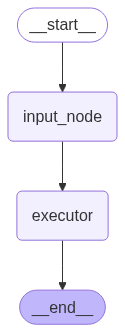

--- 노드 실행: input_node ---
--- 노드 실행: execution_node ---
--- TOOL: get_parameter_from_db(step_name='포토리소그래피') 실행 ---

--- 최종 실행 결과 ---
{'query': '포토리소그래피', 'tool_output': 'Dose: 25.0, Focus: -0.05'}


In [ ]:
# 기본 그래프 생성 (executor -> END)
base_workflow = StateGraph(AgentState)
base_workflow.set_entry_point("input_node")
base_workflow.add_node("input_node", input_node)
base_workflow.add_node("executor", execution_node)
base_workflow.add_edge("input_node", "executor")
base_workflow.add_edge("executor", END) # 초기에는 executor가 바로 종료됨

app = base_workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

# 실행
# '포토리소그래피'를 쿼리하면 quality_check가 True를 반환
result = app.invoke({"query": "포토리소그래피"})

print("\n--- 최종 실행 결과 ---")
print(result)

> add_quality_check_to_graph 함수를 호출하여 구조를 변경한 뒤 컴파일, 실행


>>> 그래프 구조 동적 수정 중... (Hot-Swapping) <<<
>>> 'quality_checker' 노드 및 엣지 추가 완료. <<<



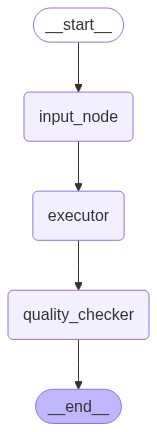

--- 노드 실행: input_node ---
--- 노드 실행: execution_node ---
--- TOOL: get_parameter_from_db(step_name='포토리소그래피') 실행 ---
--- 노드 실행: quality_check_node ---
--- TOOL: quality_check(data='Dose: 25.0, Focus: -0.05') 실행 ---

--- 최종 실행 결과 ---
{'query': '포토리소그래피', 'tool_output': 'Dose: 25.0, Focus: -0.05', 'quality_ok': True}


In [ ]:
# 런타임에 그래프 구조 수정
# 특정 조건(예: is_qc_required = True)에 따라 호출될 수 있음
is_qc_required = True
if is_qc_required:
    add_quality_check_to_graph(base_workflow)

# 수정된 그래프 컴파일
app = base_workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

# 실행
# '포토리소그래피'를 쿼리하면 quality_check가 True를 반환
result = app.invoke({"query": "포토리소그래피"})

print("\n--- 최종 실행 결과 ---")
print(result)

## 피드백 기반 경로 보정  
### 외부 피드백(예: 이전 실행의 정확도 점수)에 따라 그래프의 실행 경로를 동적으로 변경하는 조건부 분기를 구현




### 경로 보정을 위한 노드 및 조건 함수 정의

In [ ]:
# 상태 정의 (피드백 필드 추가)
class FeedbackState(TypedDict):
    query: str
    feedback: dict # 예: {'accuracy': 0.6}
    result: str

## 각기 다른 로직을 가진 두 개의 실행 노드 정의
# 표준 실행 경로: 간단한 DB 조회
def standard_execution_node(state: FeedbackState) -> dict:
    print("--- 노드 실행: standard_execution_node (표준 경로) ---")
    res = get_parameter_from_db(state['query'])
    return {"result": res}

# 대안 실행 경로: LLM을 사용하여 더 상세한 설명 생성
def alternative_execution_node(state: FeedbackState) -> dict:
    print("--- 노드 실행: alternative_execution_node (대안 경로) ---")
    prompt = f"'{state['query']}' 공정에 대해 DB에서 데이터를 찾지 못했거나 정확도가 낮았습니다. 이 공정에 대해 아는 대로 상세히 설명해주세요."
    res = llm.invoke(prompt).content
    return {"result": res}

## 피드백에 따라 경로를 결정하는 조건 함수
# 피드백의 정확도 점수에 따라 실행할 경로를 반환
def route_based_on_feedback(state: FeedbackState) -> str:
    print("--- 조건 확인: route_based_on_feedback ---")
    accuracy = state.get("feedback", {}).get("accuracy", 1.0)
    if accuracy < 0.8:
        print("-> 정확도 낮음. 'alternative_path'로 분기")
        return "alternative_path"
    else:
        print("-> 정확도 높음. 'standard_path'로 분기")
        return "standard_path"

### 피드백 기반 조건부 그래프 구성 및 실행   
>add_conditional_edges를 사용하여  
route_based_on_feedback 함수의 반환값에 따라 다음 노드를 동적으로 선택



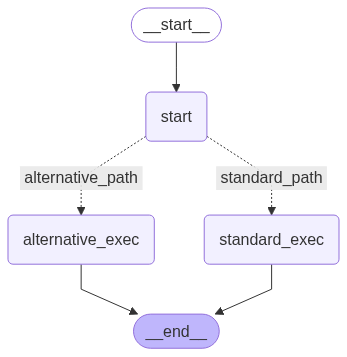

--- 검증 1: 정확도가 높은 경우 (표준 경로) ---
--- 조건 확인: route_based_on_feedback ---
-> 정확도 높음. 'standard_path'로 분기
--- 노드 실행: standard_execution_node (표준 경로) ---
--- TOOL: get_parameter_from_db(step_name='식각') 실행 ---
최종 결과: Power: 500, Pressure: 10



In [ ]:
feedback_workflow = StateGraph(FeedbackState)

# 더미 시작 노드
feedback_workflow.set_entry_point("start")
feedback_workflow.add_node("start", lambda state: {})

# 실행 노드들 추가
feedback_workflow.add_node("standard_exec", standard_execution_node)
feedback_workflow.add_node("alternative_exec", alternative_execution_node)

# 조건부 엣지 설정
feedback_workflow.add_conditional_edges(
    "start", # 이 노드 다음에 분기
    route_based_on_feedback, # 경로 결정 함수
    {
        "standard_path": "standard_exec",      # 'standard_path' return
        "alternative_path": "alternative_exec" # 'alternative_path' return
    }
)

# 어떤 경로를 타든 실행 후 종료
feedback_workflow.add_edge("standard_exec", END)
feedback_workflow.add_edge("alternative_exec", END)

# 컴파일
feedback_app = feedback_workflow.compile()
display(Image(feedback_app.get_graph().draw_mermaid_png()))

# --- 검증 ---
print("--- 검증 1: 정확도가 높은 경우 (표준 경로) ---")
good_feedback = {"query": "식각", "feedback": {"accuracy": 0.95}}
result1 = feedback_app.invoke(good_feedback)
print(f"최종 결과: {result1['result']}\n")

--- 검증 2: 정확도가 낮은 경우 (대안 경로) ---
--- 조건 확인: route_based_on_feedback ---
-> 정확도 낮음. 'alternative_path'로 분기
--- 노드 실행: alternative_execution_node (대안 경로) ---
최종 결과: 이온 주입(Ion Implantation)은 반도체 제조 공정에서 매우 중요한 단계 중 하나로, 웨이퍼 표면에 특정한 불순물 이온을 주입하여 반도체의 전기적 특성을 조절하는 기술입니다. 이 공정은 주로 트랜지스터의 소스(source)와 드레인(drain) 영역을 형성하거나, 웰(well) 및 채널(channel) 도핑을 위해 사용됩니다.

### 이온 주입 공정의 주요 단계:

1. **이온 소스 생성**: 
   - 특정한 불순물 원소(예: 붕소, 인, 비소 등)를 기체 상태로 만들어 이온화합니다. 이온화된 불순물 원소는 전하를 띠게 됩니다.

2. **이온 가속**:
   - 이온화된 불순물은 전기장에 의해 가속됩니다. 이 과정에서 이온의 에너지가 결정되며, 이는 웨이퍼 내로 주입되는 깊이에 영향을 미칩니다.

3. **이온 주입**:
   - 가속된 이온은 웨이퍼 표면에 충돌하여 내부로 주입됩니다. 이때 이온의 에너지와 각도에 따라 주입 깊이와 분포가 결정됩니다.

4. **주입 후 열처리(어닐링)**:
   - 주입된 이온들이 웨이퍼 내에서 활성화되도록 열처리를 합니다. 이 과정에서 결정 격자 내에 자리 잡지 못한 이온들이 제자리를 찾아가고, 손상된 결정 구조가 회복됩니다.

### 이온 주입의 장점:

- **정밀한 도핑 제어**: 주입되는 이온의 양과 깊이를 매우 정밀하게 조절할 수 있어, 원하는 전기적 특성을 정확히 구현할 수 있습니다.
- **낮은 온도 공정**: 다른 도핑 방법에 비해 상대적으로 낮은 온도에서 공정이 이루어져, 열에 민감한 공정 단계와의 호환성이 좋습니다.
- **다양한 도핑 프로파일 구현**: 다양한 에너지와 각도로 이온을 주입함으로써 복잡

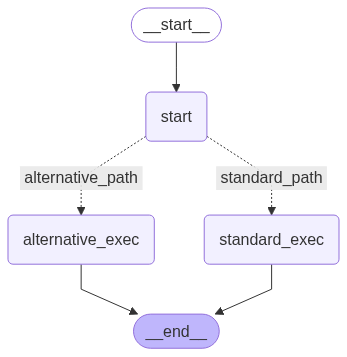

In [ ]:
print("--- 검증 2: 정확도가 낮은 경우 (대안 경로) ---")
bad_feedback = {"query": "이온 주입", "feedback": {"accuracy": 0.7}}
result2 = feedback_app.invoke(bad_feedback)
print(f"최종 결과: {result2['result']}")
display(Image(feedback_app.get_graph().draw_mermaid_png()))


## 오류 재시도 루프  
###  특정 작업이 실패했을 때 최대 2회까지 자동으로 재시도하는 Loop를 그래프에 구현



> get_parameter_from_db 도구가 간헐적으로 실패한다고 가정하고,  
실패 시 상태의 retry_count를 1씩 증가시키며,   
2회가 되기 전까지는 다시 시도하고,   
2회를 초과하면 최종 실패로 처리하는 조건부 그래프 만들기  



In [ ]:
import random

# 재시도 로직을 위한 상태 및 도구 정의
class RetryState(TypedDict):
    query: str
    result: str
    retry_count: int

# 50% 확률로 실패를 시뮬레이션하는 도구
def flaky_db_tool(step_name: str) -> str:
    """50% 확률로 실패하는 DB 조회 툴"""
    print(f"--- TOOL: flaky_db_tool(step_name='{step_name}') 실행 ---")
    if random.random() < 0.5:
        # 실패 시 에러 메시지 반환
        print(">>> DB 조회 실패! (시뮬레이션) <<<")
        return "Error: Transient DB Error"
    else:
        # 성공
        print(">>> DB 조회 성공! <<<")
        return get_parameter_from_db(step_name)

## 재시도 로직을 포함한 노드 및 조건 함수
#  재시도 횟수를 1 증가시키고, 실패 가능한 도구를 호출
def db_with_retry_node(state: RetryState) -> dict:
    print(f"\n--- 노드 실행: db_with_retry_node (시도 횟수: {state['retry_count'] + 1}) ---")
    # 실행 전 재시도 횟수 업데이트
    retries = state.get("retry_count", 0) + 1

    result = flaky_db_tool(state['query']) # 50% 확률로 실패하는 도구
    return {"result": result, "retry_count": retries}

def should_retry(state: RetryState) -> str:
    """결과에 에러가 있고, 재시도 횟수가 2회 미만인지 확인하여 분기합니다."""
    print("--- 조건 확인: should_retry ---")
    max_retries = 2
    if "Error" in state["result"]:
        if state["retry_count"] < max_retries:
            print(f"-> 실패. 재시도합니다. (현재 {state['retry_count']}회)")
            return "retry" # 자기 자신으로 돌아가는 루프
        else:
            print(f"-> 실패. 최대 재시도 횟수({max_retries}회) 초과.")
            return "failure" # 최종 실패
    else:
        print("-> 성공. 종료합니다.")
        return "success" # 정상 종료

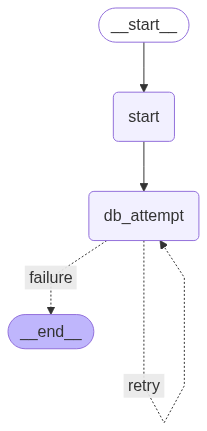

In [ ]:
# 재시도 루프를 포함한 그래프 구성
retry_workflow = StateGraph(RetryState)

# 시작 시 retry_count를 0으로 초기화
retry_workflow.set_entry_point("start")
retry_workflow.add_node("start", lambda state: {"retry_count": 0})

retry_workflow.add_node("db_attempt", db_with_retry_node)
retry_workflow.add_edge("start", "db_attempt")

# db_attempt 노드 실행 후, should_retry 조건에 따라 분기
retry_workflow.add_conditional_edges(
    "db_attempt",             # db_with_retry_node 실행
    should_retry,             # 재시도 체크
    {
        "retry": "db_attempt",# 다시 db_with_retry_node 실행
        "success": END,
        "failure": END        # 최종 실패
    }
)

# 컴파일
retry_app = retry_workflow.compile()
display(Image(retry_app.get_graph().draw_mermaid_png()))

In [ ]:
# --- 검증 ---
# 여러 번 실행해보면, 재시도하는 로그와 최종 성공/실패 결과가 다르게 나옴
print("--- 재시도 루프 검증 실행 ---")
final_result = retry_app.invoke({"query": "포토리소그래피"})

print("\n\n--- 최종 실행 결과 ---")
print(final_result)

--- 재시도 루프 검증 실행 ---

--- 노드 실행: db_with_retry_node (시도 횟수: 1) ---
--- TOOL: flaky_db_tool(step_name='포토리소그래피') 실행 ---
>>> DB 조회 실패! (시뮬레이션) <<<
--- 조건 확인: should_retry ---
-> 실패. 재시도합니다. (현재 1회)

--- 노드 실행: db_with_retry_node (시도 횟수: 2) ---
--- TOOL: flaky_db_tool(step_name='포토리소그래피') 실행 ---
>>> DB 조회 성공! <<<
--- TOOL: get_parameter_from_db(step_name='포토리소그래피') 실행 ---
--- 조건 확인: should_retry ---
-> 성공. 종료합니다.


--- 최종 실행 결과 ---
{'query': '포토리소그래피', 'result': 'Dose: 25.0, Focus: -0.05', 'retry_count': 2}


## 대규모 협업 시나리오  
###  '감독(Coordinator)' 노드가 사용자의 복잡한 요청을 분석하여 여러 개의 하위 작업으로 나눈 뒤,  
### 각 작업을 '작업자(Worker)' 노드에 분배하여 처리하고,   
### 마지막에 결과를 종합하는 '멀티 에이전트 협업' 패턴 구현

### 감독-작업자 (Supervisor-Worker) 패턴   

1. 감독 (Coordinator):  
사용자의 복잡한 요청(예: "A도 해주고 B도 찾아줘")을 받습니다. LLM을 사용하여 이 요청을 단일 작업을 수행하는 여러 개의 명확한 지시사항(sub-tasks)으로 분해합니다. (예: ['A 작업 지시', 'B 작업 지시'])
2.작업자 (Worker):  
분배된 개별 지시사항을 받아, 각자 맡은 도구를 사용하여 작업을 실행합니다. 이번 실습에서는 하나의 worker_node가 여러 종류의 작업을 처리하도록 구현하여 효율성을 높입니다.
3. 병합/요약 (Reducer/Summarizer):  
모든 작업자들이 실행을 마친 뒤, 각자의 결과물을 모아 최종적으로 하나의 종합적인 답변으로 만들어 사용자에게 제공합니다.

In [12]:
# 가상 매뉴얼 파일 생성
with open("DUV_manual.txt", "w", encoding="utf-8") as f:
    f.write("DUV 공정의 핵심은 193nm 파장의 빛을 사용하여 미세 패턴을 형성하는 것입니다.")

def load_manual(path: str) -> str:
    """매뉴얼 파일을 로딩하는 툴"""
    print(f"--- TOOL: load_manual(path='{path}') 실행 ---")
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        return f"파일을 찾을 수 없습니다: {path}"

In [13]:
# 협업 시나리오를 위한 상태 정의
class CollaborationState(TypedDict):
    original_query: str
    tasks: List[str]         # 감독 노드가 생성한 작업 리스트
    results: List[str]       # 작업자 노드가 실행한 결과 리스트
    final_summary: str       # 최종 요약 답변

# 협업 그래프의 노드 함수 정의

def coordinator_node(state: CollaborationState) -> dict:
    """사용자의 원본 쿼리를 받아, 여러 작업자에게 분배할 작업 리스트를 생성합니다."""
    print("--- 노드 실행: coordinator_node (작업 분배) ---")
    query = state['original_query']

    prompt = f"""
당신은 여러 전문가 팀을 관리하는 프로젝트 매니저입니다. 사용자의 복잡한 요청을 분석하여, 각 전문가(도구)가 처리할 수 있는 간단한 작업 단위로 분해해주세요.
각 작업은 '도구:요청사항' 형식이어야 합니다. 응답은 반드시 파이썬 리스트(list) 형식의 문자열로만 생성해야 합니다.

사용 가능한 도구:
- `DB_QUERY:공정명`: 데이터베이스에서 공정 데이터를 조회합니다.
- `MANUAL_QUERY:검색어`: DUV 매뉴얼에서 관련 내용을 찾습니다.

# 요청: {query}
# 작업 분해 결과 (파이썬 리스트 형식):
"""
    # LLM을 사용하여 작업 계획 생성
    response = llm.invoke(prompt).content

    # LLM 응답에서 Markdown 코드 블록 제거 및 파싱
    cleaned_content = response.strip().replace("```python", "").replace("```", "").strip()
    tasks = ast.literal_eval(cleaned_content)

    print(f"생성된 작업 리스트: {tasks}")
    return {"tasks": tasks}


def worker_node(state: CollaborationState) -> dict:
    """분배된 작업 리스트를 받아, 각 작업을 순차적으로 실행합니다."""
    print("--- 노드 실행: worker_node (개별 작업 처리) ---")
    tasks = state['tasks']
    results = []
    for task in tasks:
        if task.startswith("DB_QUERY:"):
            _, step_name = task.split(":", 1)
            results.append(get_parameter_from_db(step_name))
        elif task.startswith("MANUAL_QUERY:"):
            _, search_term = task.split(":", 1)
            # 실제로는 여기서 매뉴얼 검색 로직이 들어가야 하지만, 예제에서는 고정된 값을 반환합니다.
            results.append(load_manual("DUV_manual.txt"))
        else:
            results.append(f"알 수 없는 작업: {task}")

    return {"results": results}


def reducer_node(state: CollaborationState) -> dict:
    """모든 작업 결과를 종합하여 최종 답변을 생성합니다."""
    print("--- 노드 실행: reducer_node (결과 종합) ---")
    query = state['original_query']
    results_str = "\n".join(state['results'])

    prompt = f"""
사용자의 원본 요청과 각 전문가가 수행한 작업 결과가 아래에 있습니다.
이 정보들을 모두 종합하여 사용자에게 제공할 최종 보고서를 자연스러운 문장으로 작성해주세요.

# 원본 요청: {query}
# 작업 결과:
{results_str}

# 최종 종합 보고서:
"""
    summary = llm.invoke(prompt).content
    return {"final_summary": summary}

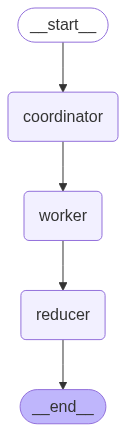

In [14]:
# 협업 그래프 구성
from langgraph.graph import StateGraph, END
import ast # ast 임포트 확인

collab_workflow = StateGraph(CollaborationState)

collab_workflow.add_node("coordinator", coordinator_node)
collab_workflow.add_node("worker", worker_node)
collab_workflow.add_node("reducer", reducer_node)

collab_workflow.set_entry_point("coordinator")
collab_workflow.add_edge("coordinator", "worker")
collab_workflow.add_edge("worker", "reducer")
collab_workflow.add_edge("reducer", END)

collab_app = collab_workflow.compile()
display(Image(collab_app.get_graph().draw_mermaid_png()))

In [15]:
# 4. 검증
complex_query = "DUV 공정 매뉴얼을 요약하고, 식각 공정의 DB 데이터도 알려줘"
print(f"--- 협업 에이전트 실행 (요청: {complex_query}) ---\n")

# invoke의 입력은 상태의 키와 일치해야 합니다.
final_collab_result = collab_app.invoke({"original_query": complex_query})

print("\n\n--- 최종 실행 결과 ---")
print(final_collab_result['final_summary'])

--- 협업 에이전트 실행 (요청: DUV 공정 매뉴얼을 요약하고, 식각 공정의 DB 데이터도 알려줘) ---

--- 노드 실행: coordinator_node (작업 분배) ---
생성된 작업 리스트: ['MANUAL_QUERY:DUV 공정 매뉴얼 요약', 'DB_QUERY:식각 공정']
--- 노드 실행: worker_node (개별 작업 처리) ---
--- TOOL: load_manual(path='DUV_manual.txt') 실행 ---
--- TOOL: get_parameter_from_db(step_name='식각 공정') 실행 ---
--- 노드 실행: reducer_node (결과 종합) ---


--- 최종 실행 결과 ---
DUV(Deep Ultraviolet) 공정은 193nm 파장의 빛을 사용하여 반도체 웨이퍼에 미세한 패턴을 형성하는 기술입니다. 이 공정은 고해상도의 패턴을 구현할 수 있어, 반도체 제조에서 중요한 역할을 합니다. 그러나 요청하신 식각 공정의 데이터베이스 정보는 현재 제공할 수 없습니다. 추가적인 정보가 필요하시면 다른 방법으로 문의해 주시기 바랍니다.


# State insert

```python
### 초기 상태
state = {
    "query": "포토리소그래피가 뭐야?",
    "results": [],
    "status": "pending"
}
### node return 값
return {
    "plan": ["DB_QUERY:포토리소그래피"],
    "status": "planned"
}
### state dict. update & insert
state = {
    "query": "포토리소그래피가 뭐야?",
    "results": [],
    "status": "planned",              # 'pending' -> 'planned'로 덮어쓰기됨
    "plan": ["DB_QUERY:포토리소그래피"] # 새로운 키-값으로 추가됨
}
```